In [1]:
import numpy as np
import pandas as pd
import json, csv, collections, sklearn
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, top_k_accuracy_score
from sklearn.svm import SVC
from sklearn.manifold import TSNE
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, BatchNormalization, LayerNormalization, Embedding, LSTM, Bidirectional
from keras import regularizers
from keras.callbacks import EarlyStopping
from keras.models import load_model
print(sklearn.__version__)

1.2.2


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
NUMBER_OF_DIMENSIONS = 3353

names_data = pd.read_csv("drive/MyDrive/Colab Notebooks/names.txt", names=['name'], sep=",,,,,,,")
value_counts = names_data['name'].value_counts()
frequent_values = value_counts[value_counts >= 10].index
names_data = names_data[names_data['name'].isin(frequent_values)]
index = names_data.index

vectors_data = pd.read_csv("drive/MyDrive/Colab Notebooks/vectors.txt", 
                           names=[i for i in range(NUMBER_OF_DIMENSIONS)], 
                           skiprows=lambda x: x not in index, dtype='int32')
vectors_data = vectors_data.set_index(index)


<ipython-input-3-1aab826a48b1>:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  names_data = pd.read_csv("drive/MyDrive/Colab Notebooks/names.txt", names=['name'], sep=",,,,,,,")


In [4]:
X_train, X_test, y_train, y_test = train_test_split(vectors_data, 
                                pd.get_dummies(names_data['name']), test_size=0.05,
                                stratify=names_data['name'],
                                random_state=42)
names = y_train.columns

X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.1, random_state=42)


In [5]:
# model = Sequential()
# model.add(Dense(NUMBER_OF_DIMENSIONS, input_dim=NUMBER_OF_DIMENSIONS, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(NUMBER_OF_DIMENSIONS/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
# model.add(Dropout(0.2))
# model.add(Dense(NUMBER_OF_DIMENSIONS/4, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
# model.add(Dropout(0.2))
# model.add(Dense(50, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
# model.add(Dense(len(y_train.iloc[1]), activation='softmax'))
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# model.fit(X_train, y_train, validation_data=(X_dev, y_dev), epochs=100, verbose=2, callbacks=[EarlyStopping(monitor='val_loss', patience=3)])


In [6]:
# model.save('model.h5')

In [7]:
# !cp model.h5 ./drive/MyDrive/

In [8]:
# model = load_model('./gg.h5')
model = load_model('drive/MyDrive/Colab Notebooks/embedding.h5')

hidden_model = Model(inputs=model.input, outputs=model.layers[-2].output)
code_embeddings = hidden_model.predict(X_test)
tsne = TSNE(n_components=2, random_state=49) #38 51 54
code_embeddings_2d_raw = tsne.fit_transform(code_embeddings)
code_embeddings_2d_raw[:10]

540/540 [==============================] - 1s 1ms/step


array([[   4.279422, -102.46502 ],
       [ -13.059149,   95.27289 ],
       [  78.34377 ,   17.580418],
       [ -49.36393 ,  -14.705931],
       [  11.44246 ,   75.104675],
       [  31.225834,   -6.026342],
       [ -28.424738,  -49.95292 ],
       [ -76.73046 ,   74.42503 ],
       [ -21.876942,  -86.95018 ],
       [  76.69291 ,  -45.71327 ]], dtype=float32)

In [9]:
keys_to_keep = [
    'forward',
    'fwd',
    'move',
    'mv',
    'to_address',
    'addressof',
    'max',
    'min',
    'uninitialized_copy',
    'copy_backward',
    'copy',
    'insertion_sort_incomplete',
    'sort3',
    'sort4',
    'sort5',
    'swap_bytes_16',
    'swap_bytes_32',
    'returnerrorptr',
    'returnerrorint',
    'pixreadstreamwebp',
    'pixreadstreampng',
    'pixreadstreamgif',
    'genpathname',
    'stringjoin',
    'getfilenamesindirectory',
    'splitpathatextension',
    'splitpathatdirectory',
    'db_find_by_name',
    'db_find_by_id',
    'logluvdecode32',
    'lzwdecodecompat',
    'ssl_decrypt_buf',
]

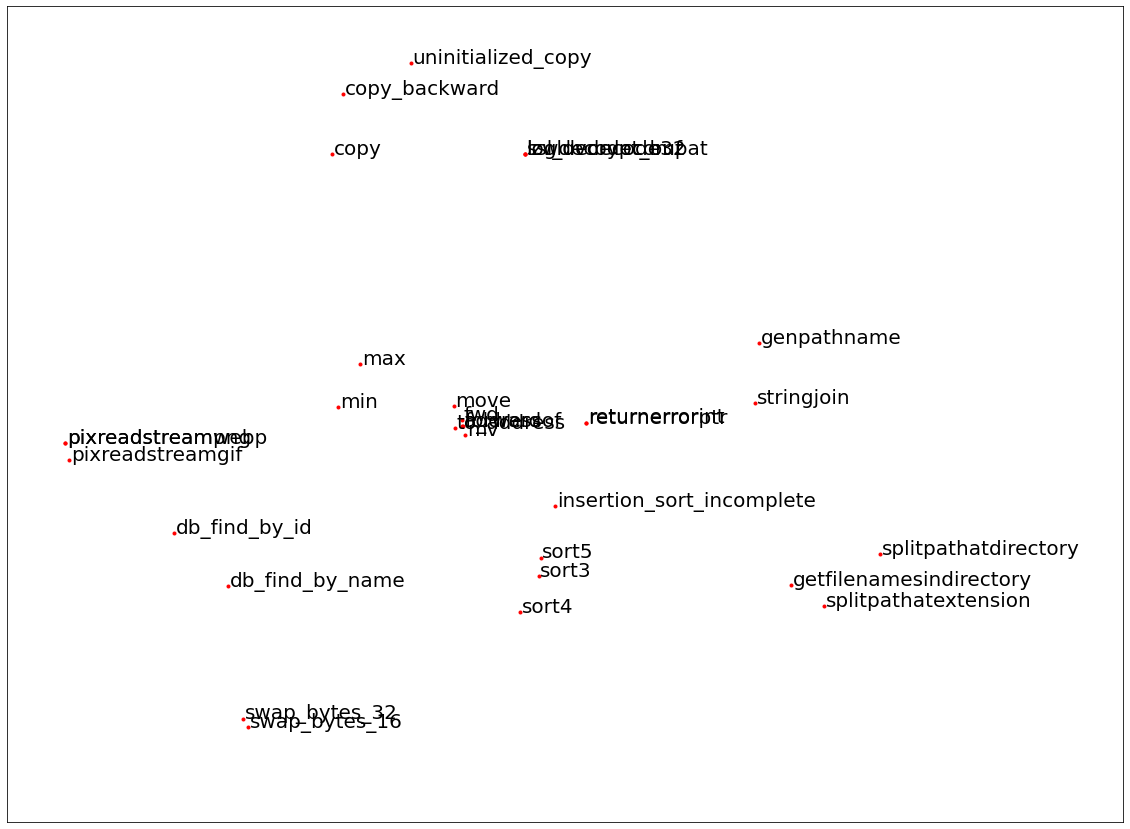

In [10]:
embed_map = {name: [] for name in list(names[np.argmax(np.array(y_test), axis=1)])}
for i, name in enumerate(list(names[np.argmax(np.array(y_test), axis=1)])):
    embed_map[name].append(code_embeddings_2d_raw[i])

for name in embed_map:
    embed_map[name] = np.mean(embed_map[name], axis=0)

embed_map = {k: v for k, v in embed_map.items() if k in keys_to_keep}

code_embeddings_2d = np.array(list(embed_map.values()))

plt.rcParams['figure.figsize'] = [20, 15]
fsize = 20
my_marker = '.'
my_color = 'red'
for name in embed_map:
    # if name == "swap_bytes_16":
    #   plt.scatter(embed_map[name][0]-0.5, embed_map[name][1]-2, marker=my_marker, color=my_color)
    #   plt.annotate(name, (embed_map[name][0], embed_map[name][1]-2), fontsize=fsize)
    # elif name == "returnerrorint":
    #   plt.scatter(embed_map[name][0]-0.5, embed_map[name][1]-4, marker=my_marker, color=my_color)
    #   plt.annotate(name, (embed_map[name][0], embed_map[name][1]-4), fontsize=fsize)
    # elif name == "ssl_decrypt_buf":
    #   plt.scatter(embed_map[name][0]-0.5, embed_map[name][1]-9, marker=my_marker, color=my_color)
    #   plt.annotate(name, (embed_map[name][0], embed_map[name][1]-9), fontsize=fsize)
    # elif name == "lzwdecodecompat":
    #   plt.scatter(embed_map[name][0]-0.5, embed_map[name][1]-4, marker=my_marker, color=my_color)
    #   plt.annotate(name, (embed_map[name][0], embed_map[name][1]-4), fontsize=fsize)
    # elif name == "pixreadstreamwebp":
    #   plt.scatter(embed_map[name][0]-0.5, embed_map[name][1]+4, marker=my_marker, color=my_color)
    #   plt.annotate(name, (embed_map[name][0], embed_map[name][1]+4), fontsize=fsize)
    # elif name == "addressof":
    #   plt.scatter(embed_map[name][0]-0.5, embed_map[name][1]-7, marker=my_marker, color=my_color)
    #   plt.annotate(name, (embed_map[name][0], embed_map[name][1]-7), fontsize=fsize)
    # elif name == "to_address":
    #   plt.scatter(embed_map[name][0]-0.5, embed_map[name][1]-11, marker=my_marker, color=my_color)
    #   plt.annotate(name, (embed_map[name][0], embed_map[name][1]-11), fontsize=fsize)
    # elif name == "mv":
    #   plt.scatter(embed_map[name][0]-0.5, embed_map[name][1]-14, marker=my_marker, color=my_color)
    #   plt.annotate(name, (embed_map[name][0], embed_map[name][1]-14), fontsize=fsize)
    # elif name == "move":
    #   plt.scatter(embed_map[name][0]-0.5, embed_map[name][1]+1, marker=my_marker, color=my_color)
    #   plt.annotate(name, (embed_map[name][0], embed_map[name][1]+1), fontsize=fsize)
    # elif name == "forward":
    #   plt.scatter(embed_map[name][0]-0.5, embed_map[name][1]-3, marker=my_marker, color=my_color)
    #   plt.annotate(name, (embed_map[name][0], embed_map[name][1]-3), fontsize=fsize)
    # else:
      plt.scatter(embed_map[name][0]-0.5, embed_map[name][1], marker=my_marker, color=my_color)
      plt.annotate(name, (embed_map[name][0], embed_map[name][1]), fontsize=fsize)
ax = plt.gca()
ax.set_xlim(right=180, left=-130)
ax.set_ylim(top=110, bottom=-80)
ax.set_xticks([])
ax.set_yticks([])
plt.savefig('my_plot.pdf', format='pdf', bbox_inches='tight', pad_inches=0)
plt.show()